# Importing data

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import preprocessing
import AutoClean as ac
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 30
pd.options.display.max_columns = 30
label_encoder = preprocessing.LabelEncoder()

account_df = pd.read_csv('data/account.csv',sep=';',na_values=['NaN'])
card_df = pd.read_csv('data/card_dev.csv', sep=';',na_values=['NaN'])
client_df = pd.read_csv('data/client.csv',sep=';',na_values=['NaN'])
disp_df = pd.read_csv('data/disp.csv',sep=';',na_values=['NaN'])
district_df = pd.read_csv('data/district.csv',sep=';',na_values=['NaN'])
loan_df = pd.read_csv('data/loan_dev.csv', sep=';',na_values=['NaN'])
trans_df = pd.read_csv("data/trans_dev.csv",sep=";", low_memory=False,na_values=['NaN'])



# Account Stats

#### Data cleaning, transformation and data quality changes

In [2]:
account_df = pd.read_csv('data/account.csv',sep=';',na_values=['NaN'])
account_df.head()

,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102


In [3]:


account_df.rename(columns={'frequency':'account_frequency'}, inplace=True)
account_df.rename(columns={'date':'account_date'}, inplace=True)

account_df.loc[account_df['account_frequency'] == 'monthly issuance', 'account_frequency'] = 'monthly'
account_df.loc[account_df['account_frequency'] == 'weekly issuance', 'account_frequency'] = 'weekly'
account_df.loc[account_df['account_frequency'] == 'issuance after transaction', 'account_frequency'] = 'after-transaction'

print(account_df.isnull().sum())
#Frequency from text data to numerical
account_df['account_frequency']= label_encoder.fit_transform(account_df['account_frequency'])



account_df['account_date'] = pd.to_datetime(account_df['account_date'], format='%y%m%d')

acount_date_year = []
for i in account_df.index:
    acount_date_year.append(account_df['account_date'][i].year)
    
#account age days
account_df['account_age_days'] = (datetime.now() - account_df['account_date']).dt.days
account_df.rename(columns={'district_id':'account_district_number'}, inplace=True)

account_df['account_year'] = acount_date_year
account_df
#account_df.drop(columns=account_df.columns[0], axis=1, inplace=True)
#account_df.drop(columns=['account_date'], axis=1, inplace=True)
print(account_df.head())
print(account_df.dtypes)
account_df.to_csv('refined/account.csv',sep=';',index=False)

account_id           0
district_id          0
account_frequency    0
account_date         0
dtype: int64
   account_id  account_district_number  account_frequency account_date  \
0         576                       55                  1   1993-01-01   
1        3818                       74                  1   1993-01-01   
2         704                       55                  1   1993-01-01   
3        2378                       16                  1   1993-01-01   
4        2632                       24                  1   1993-01-02   

   account_age_days  account_year  
0             10921          1993  
1             10921          1993  
2             10921          1993  
3             10921          1993  
4             10920          1993  
account_id                          int64
account_district_number             int64
account_frequency                   int64
account_date               datetime64[ns]
account_age_days                    int64
account_year            

# Client Processing


#### Data cleaning, transformation and data quality changes

In [4]:
client_df = pd.read_csv('data/client.csv',sep=';',na_values=['NaN'])
client_df.head()


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [5]:

client_df.describe()

,client_id,birth_number,district_id
count,5369.000000,5369.000000,5369.000000
mean,3359.011920,535114.970013,37.310114
std,2832.911984,172895.618429,25.043690
min,1.000000,110820.000000,1.000000
25%,1418.000000,406009.000000,14.000000
50%,2839.000000,540829.000000,38.000000
75%,4257.000000,681013.000000,60.000000
max,13998.000000,875927.000000,77.000000


In [6]:
client_df.rename(columns={'district_id':'client_district_id'}, inplace=True)
client_df.rename(columns={'birth_number':'client_birth_number'}, inplace=True)


age = []
gender = []
birth = []
get_birth_date = lambda x : pd.to_datetime('19'+str(x)[0:2] + str(x)[2:4] + str(x)[4:6])
for x in client_df['client_birth_number']:
    month = int(str(x)[2:4])
    if month > 12:
        gender.append('F')
        x -= 5000
    else:
        gender.append('M')
    
    birth_date = get_birth_date(x)
    birth.append(birth_date)
    age.append((datetime.now() - birth_date).days // 365)

client_df['client_birth_number'] = birth

birth_year = []
for i in client_df.index:
    birth_year.append(client_df['client_birth_number'][i].year)

client_df['birth_year'] = birth_year
    

client_df['client_age'] = age
client_df['client_gender'] = gender

#visualization
#clients % gender
#client_gender_distr = client_df.groupby(['client_gender']["client_gender"].count().reset_index(name="count")).sort_values(['count'], ascending=False)
#print(client_gender_distr)


client_df['client_gender']= label_encoder.fit_transform(client_df['client_gender'])

#client_df.drop(columns=['client_birth_number'], axis=1, inplace=True)

client_df.to_csv('refined/client.csv',sep=';',index=False)


In [7]:
client_df.head()

,client_id,client_birth_number,client_district_id,birth_year,client_age,client_gender
0,1,1970-12-13,18,1970,51,0
1,2,1945-02-04,1,1945,77,1
2,3,1940-10-09,1,1940,82,0
3,4,1956-12-01,5,1956,66,1
4,5,1960-07-03,5,1960,62,0


# Disposition Processing

#### Data cleaning, transformation and data quality changes

In [8]:

disp_df = pd.read_csv('data/disp.csv',sep=';',na_values=['NaN'])
print(disp_df.isnull().sum())

disp_df.describe()
disp_df.head()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [9]:
#change typpe to boolean
disp_df["account_owner"] = disp_df.apply(lambda x: True if x['type'].replace('"','') =='OWNER' else False, axis=1)
disp_df.drop(columns=['type'], inplace=True)

disp_df.to_csv('refined/disposition.csv',sep=';',index=False)


In [10]:
disp_df.head(10)

,disp_id,client_id,account_id,account_owner
0,1,1,1,True
1,2,2,2,True
2,3,3,2,False
3,4,4,3,True
4,5,5,3,False
5,6,6,4,True
6,7,7,5,True
7,8,8,6,True
8,9,9,7,True
9,10,10,8,True


Check that visualization: we have 4500 owners = number of accounts: we have accounts with 1 owner and 1 disponent and an account have always 1 owner

# Transaction Processing

In [11]:
trans_df = pd.read_csv('data/trans_dev.csv',sep=';',na_values=['NaN'])
trans_df.rename(columns={'date' : 'trans_date'}, inplace=True)
trans_df.rename(columns={'type' : 'trans_type'}, inplace=True)
trans_df.rename(columns={'operation' : 'trans_operation'}, inplace=True)
trans_df.rename(columns={'amount' : 'trans_amount'}, inplace=True)
trans_df.rename(columns={'balance' : 'trans_balance'}, inplace=True)
trans_df.rename(columns={'k_symbol' : 'trans_k_symbol'}, inplace=True)
trans_df.rename(columns={'bank' : 'trans_bank'}, inplace=True)
trans_df.rename(columns={'account': 'trans_account'}, inplace=True)

trans_df['trans_date'] = pd.to_datetime(trans_df['trans_date'], format='%y%m%d',errors="coerce")

trans_date_year = []
trans_date_month = []
trans_date_day = []
for i in trans_df.index:
    trans_date_year.append(trans_df['trans_date'][i].year)
    # trans_date_month.append(trans_df['trans_date'][i].month)
    # trans_date_day.append(trans_df['trans_date'][i].day)

trans_df['trans_year'] = trans_date_year
# trans_df['trans_month'] = trans_date_month
# trans_df['trans_day'] = trans_date_day

#as colunas bank e account não são necessárias, trans_k_symbol têm muitos valores nulos
trans_df.drop(['trans_bank', 'trans_account'], axis=1, inplace=True)

trans_df.loc[trans_df["trans_operation"].isnull(),"trans_operation"] = "interest_credit" # ver explicação em data processing ac

#for now:

trans_df.loc[trans_df["trans_k_symbol"].isnull(),"trans_k_symbol"] = "no_trans_k_symbol"
#se for withdrawal, o ammount é negativo
# trans_df.loc[trans_df["trans_type"]=="withdrawal","trans_amount"] *= -1
# trans_df.loc[trans_df["trans_type"]=="withdrawal in cash","trans_amount"] *= -1

trans_df["trans_amount"] = trans_df["trans_amount"] / 1.0
trans_df["trans_balance"] = trans_df["trans_balance"] / 1.0

# check people with negative balance

neg_balance = trans_df[trans_df["trans_balance"] < 0]
neg_balance.drop(neg_balance.columns.difference(['account_id','trans_balance']), 1, inplace=True)

neg_balance["check_negative_balance"] = True


neg_balance.drop('trans_balance', axis=1).set_index('account_id')

# simplify transactions by: per_acccount id, first transfer, had negative balance etc

get_negative = neg_balance["account_id"].unique()

process_lambda = lambda x: True if x["account_id"] in get_negative else False

trans_df["check_negative_balance"] = trans_df.apply(process_lambda, axis=1)



In [14]:


trans_df.head()


,trans_id,account_id,trans_date,trans_type,trans_operation,trans_amount,trans_balance,trans_k_symbol,trans_year,check_negative_balance
0,1548749,5270,1993-01-13,credit,credit in cash,800.0,800.0,no_trans_k_symbol,1993,False
1,1548750,5270,1993-01-14,credit,collection from another bank,44749.0,45549.0,no_trans_k_symbol,1993,False
2,3393738,11265,1993-01-14,credit,credit in cash,1000.0,1000.0,no_trans_k_symbol,1993,False
3,3122924,10364,1993-01-17,credit,credit in cash,1100.0,1100.0,no_trans_k_symbol,1993,False
4,1121963,3834,1993-01-19,credit,credit in cash,700.0,700.0,no_trans_k_symbol,1993,False


In [15]:
print(neg_balance)


        account_id  trans_balance  check_negative_balance
3818          5442         -815.0                    True
4954         11021         -517.7                    True
5031          3166         -385.5                    True
5052          3166        -2485.5                    True
5172          3166        -2402.8                    True
...            ...            ...                     ...
393834        3407         -375.5                    True
394382        3407         -393.5                    True
395047        6463       -10341.2                    True
395048        6463       -10323.3                    True
396589         635         -439.0                    True

[512 rows x 3 columns]


In [16]:



trans_df.to_csv('refined/transaction.csv',sep=';',index=False)
trans_df.head()

,trans_id,account_id,trans_date,trans_type,trans_operation,trans_amount,trans_balance,trans_k_symbol,trans_year,check_negative_balance
0,1548749,5270,1993-01-13,credit,credit in cash,800.0,800.0,no_trans_k_symbol,1993,False
1,1548750,5270,1993-01-14,credit,collection from another bank,44749.0,45549.0,no_trans_k_symbol,1993,False
2,3393738,11265,1993-01-14,credit,credit in cash,1000.0,1000.0,no_trans_k_symbol,1993,False
3,3122924,10364,1993-01-17,credit,credit in cash,1100.0,1100.0,no_trans_k_symbol,1993,False
4,1121963,3834,1993-01-19,credit,credit in cash,700.0,700.0,no_trans_k_symbol,1993,False


- check distribution of k_symbol values
- check we have a lot more no bank values so we will drop that

#### Data cleaning, transformation and data quality changes to check if we decide to use k_symbol using some techniques for null values

In [57]:
# trans_df.rename(columns={'date' : 'trans_date'}, inplace=True)
# trans_df.rename(columns={'type' : 'trans_type'}, inplace=True)
# trans_df.rename(columns={'operation' : 'trans_operation'}, inplace=True)
# trans_df.rename(columns={'amount' : 'trans_amount'}, inplace=True)
# trans_df.rename(columns={'balance' : 'trans_balance'}, inplace=True)
# trans_df.rename(columns={'k_symbol' : 'trans_k_symbol'}, inplace=True)
# trans_df.rename(columns={'bank' : 'trans_bank'}, inplace=True)
# trans_df.rename(columns={'account': 'trans_account'}, inplace=True)

# trans_df['trans_date'] = pd.to_datetime(trans_df['trans_date'], format='%y%m%d')

# trans_date_year = []
# for i in trans_df.index:
#     trans_date_year.append(trans_df['trans_date'][i].year)

# trans_df['trans_year'] = trans_date_year
# print(trans_df.head())

# #as colunas bank e account não são necessárias, trans_k_symbol têm muitos valores nulos
# #trans_df.drop(['trans_bank', 'trans_account', ], axis=1)

# #withdrawal in cash para withdrawal
# trans_df.loc[trans_df["trans_type"]=="withdrawal in cash","trans_type"] = "withdrawal" 
# trans_df.loc[trans_df["trans_operation"].isnull(),"trans_operation"] = "other_type"
# #se for withdrawal, o ammount é negativo
# trans_df.loc[trans_df["trans_type"]=="withdrawal","trans_amount"] *= -1



# trans_df.to_csv('refined/transaction.csv',sep=';',index=False)


# Loan Processing

#### Data cleaning, transformation and data quality changes

In [17]:
loand_df = pd.read_csv('data/loan_dev.csv',sep=';',na_values=['NaN'])
loan_df.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


In [18]:

loan_df.rename(columns={'date':'loan_date'}, inplace=True)
loan_df.rename(columns={'amount':'loan_amount'}, inplace=True)
loan_df.rename(columns={'duration':'loan_duration'}, inplace=True)
loan_df.rename(columns={'payments':'loan_payments'}, inplace=True)
loan_df.rename(columns={'status':'loan_status'}, inplace=True)
loan_df.loc[loan_df["loan_status"]== -1,"loan_status"] *= 0

loan_df['loan_date'] = pd.to_datetime(loan_df['loan_date'], format='%y%m%d')

loan_date_year = []
for i in loan_df.index:
    loan_date_year.append(loan_df['loan_date'][i].year)
loan_df['loan_year'] = loan_date_year



In [20]:
loan_df.head()

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,loan_year
0,5314,1787,1993-07-05,96396,12,8033,0,1993
1,5316,1801,1993-07-11,165960,36,4610,1,1993
2,6863,9188,1993-07-28,127080,60,2118,1,1993
3,5325,1843,1993-08-03,105804,36,2939,1,1993
4,7240,11013,1993-09-06,274740,60,4579,1,1993


In [21]:
loand_df.describe()
print(loand_df.nunique())


loan_id       328
account_id    328
date          283
amount        316
duration        5
payments      300
status          2
dtype: int64


In [22]:

print(loand_df.count())

loan_id       328
account_id    328
date          328
amount        328
duration      328
payments      328
status        328
dtype: int64


- Duration has 5 possible values in years
- status has 2 possible values
- no duplicates
- no null values

In [23]:
# transform duration, amount and payments to numerics
loand_df['duration'] = pd.to_numeric(loand_df['duration'], errors='coerce').astype('int')


loand_df['amount'] = pd.to_numeric(loand_df['amount'], errors='coerce').astype('int')


loand_df['payments'] = pd.to_numeric(loand_df['payments'], errors='coerce').astype('int')


loand_df.dtypes

loan_id       int64
account_id    int64
date          int64
amount        int64
duration      int64
payments      int64
status        int64
dtype: object

- distribution of status on loans is unbalanced more then 80% paid the loans: check more thi-
- distribution of duration on loans is more or less balanced

In [24]:

loan_df.to_csv('refined/loan.csv',sep=';',index=False)

# Credit Card Processing

#### Data cleaning, transformation and data quality changes

In [80]:
card_df = pd.read_csv('data/card_dev.csv', sep=';')
card_df.rename(columns={'type' : 'card_type'}, inplace=True)
card_df.rename(columns={'issued' : 'card_issued'}, inplace=True,errors="coerce")


card_df['card_issued'] = pd.to_datetime(card_df['card_issued'], format='%y%m%d')

issued_year = []
for i in card_df.index:
    issued_year.append(card_df['card_issued'][i].year)
#count every type of card    
#card_df['car_issued_year'] = issued_year
card_distr_type = card_df.groupby(['card_type'])['card_type'].count().reset_index(name='count').sort_values(['count'], ascending=False) 
print(card_distr_type)

#trnasform card_type into numbers -> use on data understanding
card_df['card_type']= label_encoder.fit_transform(card_df['card_type'])
#card_df.drop(['card_issued'], axis=1, inplace=True)
card_df.to_csv('refined/card.csv',sep=';',index=False)

  card_type  count
0   classic    127
2    junior     41
1      gold      9


In [81]:
card_df.dtypes


card_id                 int64
disp_id                 int64
card_type               int64
card_issued    datetime64[ns]
dtype: object

In [82]:
#get nulls
card_df.isnull().sum().sum()

0

In [83]:


card_df.head()



,card_id,disp_id,card_type,card_issued
0,1005,9285,0,1993-11-07
1,104,588,0,1994-01-19
2,747,4915,0,1994-02-05
3,70,439,0,1994-02-08
4,577,3687,0,1994-02-15


#### Data cleaning, transformation and data quality changes for card_comp

# District (demograph) Processing

#### Data cleaning, transformation and data quality changes

In [29]:
district_df = pd.read_csv('data/district.csv',sep=';',na_values=['NaN'])
district_df.head()

,code,name,region,no._of_inhabitants,no._of_municipalities_with_inhabitants_less_499,no._of_municipalities_with_inhabitants_500-1999,no._of_municipalities_with_inhabitants_2000-9999,no._of_municipalities_with_inhabitants_>10000,no._of_cities,ratio_of_urban_inhabitants,average_salary,unemploymant_rate_'95,unemploymant_rate_'96,no._of_enterpreneurs_per_1000_inhabitants,no._of_commited_crimes_'95,no._of_commited_crimes_'96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [30]:

district_df.dtypes

code                                                  int64
name                                                 object
region                                               object
no._of_inhabitants                                    int64
no._of_municipalities_with_inhabitants_less_499       int64
no._of_municipalities_with_inhabitants_500-1999       int64
no._of_municipalities_with_inhabitants_2000-9999      int64
no._of_municipalities_with_inhabitants_>10000         int64
no._of_cities                                         int64
ratio_of_urban_inhabitants                          float64
average_salary                                        int64
unemploymant_rate_'95                                object
unemploymant_rate_'96                               float64
no._of_enterpreneurs_per_1000_inhabitants             int64
no._of_commited_crimes_'95                           object
no._of_commited_crimes_'96                            int64
dtype: object

In [31]:


district_df.rename(columns={'code' : 'district_id'}, inplace=True)
district_df.rename(columns={'name' : 'district_name'}, inplace=True)
#transform names
district_df['district_name']= label_encoder.fit_transform(district_df['district_name'])
#Region attribute to numerical
district_df['region']= label_encoder.fit_transform(district_df['region'])



district_id                                           int64
district_name                                         int64
region                                                int64
no._of_inhabitants                                    int64
no._of_municipalities_with_inhabitants_less_499       int64
no._of_municipalities_with_inhabitants_500-1999       int64
no._of_municipalities_with_inhabitants_2000-9999      int64
no._of_municipalities_with_inhabitants_>10000         int64
no._of_cities                                         int64
ratio_of_urban_inhabitants                          float64
average_salary                                        int64
unemploymant_rate_'95                                object
unemploymant_rate_'96                               float64
no._of_enterpreneurs_per_1000_inhabitants             int64
no._of_commited_crimes_'95                           object
no._of_commited_crimes_'96                            int64
dtype: object

In [32]:

#treat null values and ? values

#get average of mean values unem_95 and 96 to fill with the average where we have ? and transform to numeric

no_char_col = district_df["unemploymant_rate_'95" ] != '?'
checkColl= "unemploymant_rate_'95"
mean_un_95 = pd.to_numeric(district_df[no_char_col][checkColl]).astype(float).mean()

#un96

no_char_col = district_df["no._of_commited_crimes_'95" ] != '?'
checkColl= "no._of_commited_crimes_'95"
mean_crimes_95 = pd.to_numeric(district_df[no_char_col][checkColl]).mean()

print("mean_crimes_95:",mean_crimes_95)
print("mean_un_95:",mean_un_95) # 0 a 100%


mean_crimes_95: 4850.315789473684
mean_un_95: 3.1193421052631574


In [33]:
# to numeric un95 and fill with mean
district_df.loc[district_df["unemploymant_rate_'95" ] == '?',"unemploymant_rate_'95" ] = mean_un_95
district_df.loc[district_df["no._of_commited_crimes_'95"] =='?', "no._of_commited_crimes_'95"] = mean_crimes_95

district_df["unemploymant_rate_'95"] = pd.to_numeric(district_df["unemploymant_rate_'95"], errors='coerce')




district_df["no._of_commited_crimes_'95"] = pd.to_numeric(district_df["no._of_commited_crimes_'95"], errors='coerce')

#96
no_char_col = district_df["unemploymant_rate_'96" ] != '?'
checkColl= "unemploymant_rate_'96"
mean_un_96 = pd.to_numeric(district_df[no_char_col][checkColl]).astype(float).mean()



no_char_col = district_df["no._of_commited_crimes_'96" ] != '?'
checkColl= "no._of_commited_crimes_'96"
mean_crimes_96 = pd.to_numeric(district_df[no_char_col][checkColl]).mean()

print("mean_crimes_96:",mean_crimes_96)
print("mean_un_96:",mean_un_96) # 0 a 100%


mean_crimes_96: 5030.831168831169
mean_un_96: 3.787012987012987


In [34]:
district_df.dtypes


district_id                                           int64
district_name                                         int64
region                                                int64
no._of_inhabitants                                    int64
no._of_municipalities_with_inhabitants_less_499       int64
no._of_municipalities_with_inhabitants_500-1999       int64
no._of_municipalities_with_inhabitants_2000-9999      int64
no._of_municipalities_with_inhabitants_>10000         int64
no._of_cities                                         int64
ratio_of_urban_inhabitants                          float64
average_salary                                        int64
unemploymant_rate_'95                               float64
unemploymant_rate_'96                               float64
no._of_enterpreneurs_per_1000_inhabitants             int64
no._of_commited_crimes_'95                          float64
no._of_commited_crimes_'96                            int64
dtype: object

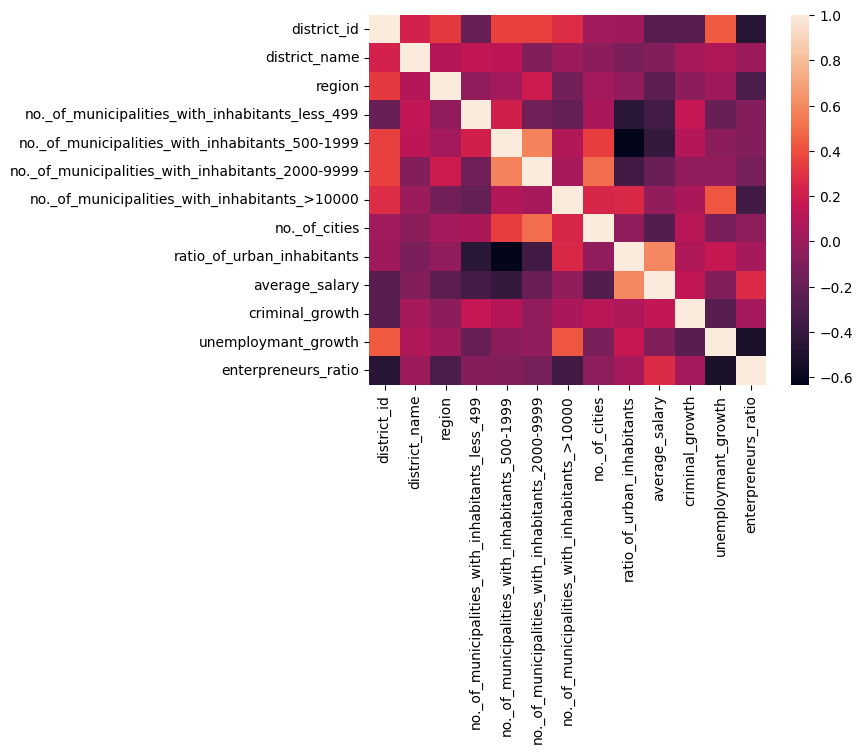

In [35]:

#growths so we can drop 96 and 95 collumns
# check the growht betwee 95 and 96
district_df["criminal_growth"] = (district_df["no._of_commited_crimes_'96"] - district_df["no._of_commited_crimes_'95"]) / district_df["no._of_inhabitants"]
district_df['unemploymant_growth'] = (district_df["unemploymant_rate_'96"] - district_df["unemploymant_rate_'95"] /100.0).round(2)
district_df["average_salary"] = (district_df["average_salary"] / 1.0).round(2)
#simplifying ratios lmao
district_df['enterpreneurs_ratio'] = district_df['no._of_enterpreneurs_per_1000_inhabitants'] / 1000.0
district_df['ratio_of_urban_inhabitants'] = (district_df['ratio_of_urban_inhabitants'] / 100.0).round(2)


district_df.drop(columns=['no._of_enterpreneurs_per_1000_inhabitants', 'no._of_inhabitants',
        "unemploymant_rate_'96", "no._of_commited_crimes_'96",
        "unemploymant_rate_'95", "no._of_commited_crimes_'95","no._of_commited_crimes_'96"], inplace=True)

corr = district_df.corr()
sns.heatmap(corr);
district_df.to_csv('refined/district.csv',sep=';',index=False)



In [36]:
district_df.head()

,district_id,district_name,region,no._of_municipalities_with_inhabitants_less_499,no._of_municipalities_with_inhabitants_500-1999,no._of_municipalities_with_inhabitants_2000-9999,no._of_municipalities_with_inhabitants_>10000,no._of_cities,ratio_of_urban_inhabitants,average_salary,criminal_growth,unemploymant_growth,enterpreneurs_ratio
0,1,17,0,0,0,0,1,1,1.00,12541.0,0.011146,0.43,0.167
1,2,0,1,80,26,6,2,5,0.47,8507.0,0.005794,1.83,0.132
2,3,1,1,55,26,4,1,5,0.42,8980.0,-0.000146,2.19,0.111
3,4,27,1,63,29,6,2,6,0.67,9753.0,0.004323,5.00,0.109
4,5,29,1,65,30,4,1,6,0.51,9307.0,0.004434,4.39,0.118


# Merging data

#### Data cleaning, transformation and data quality changes

In [172]:
refined_df = account_df.merge(disp_df, on='account_id')


In [173]:

refined_df.head()


,account_id,account_district_number,account_frequency,account_date,account_age_days,account_year,disp_id,client_id,account_owner
0,576,55,1,1993-01-01,10921,1993,692,692,True
1,576,55,1,1993-01-01,10921,1993,693,693,False
2,704,55,1,1993-01-01,10921,1993,844,844,True
3,704,55,1,1993-01-01,10921,1993,845,845,False
4,2378,16,1,1993-01-01,10921,1993,2873,2873,True


In [174]:

refined_df.shape


(5369, 9)

In [175]:
client_df.rename(columns={'client_district_id' : 'district_id'}, inplace=True)
client_district = client_df.merge(district_df, on='district_id', how='left')
client_df.rename(columns={'district_id' : 'client_district_id'}, inplace=True)


In [176]:
client_district.head()

,client_id,client_birth_number,district_id,birth_year,client_age,client_gender,district_name,region,no._of_municipalities_with_inhabitants_less_499,no._of_municipalities_with_inhabitants_500-1999,no._of_municipalities_with_inhabitants_2000-9999,no._of_municipalities_with_inhabitants_>10000,no._of_cities,ratio_of_urban_inhabitants,average_salary,criminal_growth,unemploymant_growth,enterpreneurs_ratio
0,1,1970-12-13,18,1970,51,0,46,5,60,13,2,1,4,0.65,8968.0,0.002405,3.32,0.131
1,2,1945-02-04,1,1945,77,1,17,0,0,0,0,1,1,1.00,12541.0,0.011146,0.43,0.167
2,3,1940-10-09,1,1940,82,0,17,0,0,0,0,1,1,1.00,12541.0,0.011146,0.43,0.167
3,4,1956-12-01,5,1956,66,1,29,1,65,30,4,1,6,0.51,9307.0,0.004434,4.39,0.118
4,5,1960-07-03,5,1960,62,0,29,1,65,30,4,1,6,0.51,9307.0,0.004434,4.39,0.118


In [177]:
# client_disp_df =pd.DataFrame()
#client_card = client_district.merge(card_df,)
# client_disp_df = disp_df["client_id"]
refined_df = refined_df.merge(card_df, on='disp_id',how="right")

refined_df.head()


,account_id,account_district_number,account_frequency,account_date,account_age_days,account_year,disp_id,client_id,account_owner,card_id,card_type,card_issued
0,7753,74,1,1993-02-08,10883,1993,9285,9593,True,1005,0,1993-11-07
1,489,16,1,1993-05-17,10785,1993,588,588,True,104,0,1994-01-19
2,4078,40,1,1993-01-30,10892,1993,4915,4915,True,747,0,1994-02-05
3,361,51,1,1993-02-27,10864,1993,439,439,True,70,0,1994-02-08
4,3050,60,1,1993-05-08,10794,1993,3687,3687,True,577,0,1994-02-15


In [178]:
refined_df= refined_df.merge(client_district, on="client_id",how="left")
# client_district_disp_df = client_disp_df.merge(client_district, on='client_id',how='left')
# refined_df.head()
refined_df.head()
# loan_account_trans = loan_df.merge(refined_df, on='account_id', how='inner')
# loan_account_trans.head()


,account_id,account_district_number,account_frequency,account_date,account_age_days,account_year,disp_id,client_id,account_owner,card_id,card_type,card_issued,client_birth_number,district_id,birth_year,client_age,client_gender,district_name,region,no._of_municipalities_with_inhabitants_less_499,no._of_municipalities_with_inhabitants_500-1999,no._of_municipalities_with_inhabitants_2000-9999,no._of_municipalities_with_inhabitants_>10000,no._of_cities,ratio_of_urban_inhabitants,average_salary,criminal_growth,unemploymant_growth,enterpreneurs_ratio
0,7753,74,1,1993-02-08,10883,1993,9285,9593,True,1005,0,1993-11-07,1968-01-28,74,1968,54,0,43,4,0,0,0,1,1,1.00,10673.0,-0.001343,5.39,0.100
1,489,16,1,1993-05-17,10785,1993,588,588,True,104,0,1994-01-19,1960-10-20,61,1960,62,0,67,6,139,28,5,1,6,0.54,8814.0,-0.000450,5.69,0.107
2,4078,40,1,1993-01-30,10892,1993,4915,4915,True,747,0,1994-02-05,1963-07-19,40,1963,59,1,66,3,9,16,6,3,8,0.85,9317.0,-0.000601,7.01,0.097
3,361,51,1,1993-02-27,10864,1993,439,439,True,70,0,1994-02-08,1968-09-12,51,1968,54,0,68,2,37,28,7,3,11,0.70,8541.0,0.002813,2.94,0.131
4,3050,60,1,1993-05-08,10794,1993,3687,3687,True,577,0,1994-02-15,1972-02-06,49,1972,50,1,59,2,31,28,5,1,9,0.61,8208.0,0.006117,2.24,0.155


In [179]:

refined_df= loand_df.merge(refined_df, on="account_id",how="left")


refined_df.head(40)


,loan_id,account_id,date,amount,duration,payments,status,account_district_number,account_frequency,account_date,account_age_days,account_year,disp_id,client_id,account_owner,...,birth_year,client_age,client_gender,district_name,region,no._of_municipalities_with_inhabitants_less_499,no._of_municipalities_with_inhabitants_500-1999,no._of_municipalities_with_inhabitants_2000-9999,no._of_municipalities_with_inhabitants_>10000,no._of_cities,ratio_of_urban_inhabitants,average_salary,criminal_growth,unemploymant_growth,enterpreneurs_ratio
0,5314,1787,930705,96396,12,8033,-1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5316,1801,930711,165960,36,4610,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6863,9188,930728,127080,60,2118,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5325,1843,930803,105804,36,2939,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7240,11013,930906,274740,60,4579,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,6520,7485,940316,91200,24,3800,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,6699,8330,940330,7656,24,319,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,6336,6555,940331,212400,36,5900,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,7055,10079,940406,167100,60,2785,1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
refined_df.shape


(177, 36)

In [83]:

refined_df = loan_df.merge(disp_df, on='account_id')
refined_df = refined_df.merge(client_df, on='client_id')
refined_df = refined_df.merge(account_df, on='account_id')
refined_df = refined_df.merge(district_df, left_on='client_district_id', right_on='district_id')
#refined_df = refined_df.merge(trans_df, on='account_id')
#refined_df = refined_df.merge(card_df, on='disp_id')
get_age = lambda initial_date, cur_date: cur_date.year - initial_date.year - ((cur_date.month, cur_date.day) < (initial_date.month, initial_date.day))
get_account_age = lambda initial_date,cur_date : (cur_date.year - initial_date.year) * 12 + cur_date.month - initial_date.month
refined_df['age on loan'] = refined_df.apply(lambda row: get_age(row['client_birth_number'], row['loan_date']), axis=1)
refined_df['account age at loan'] = refined_df.apply(lambda row: get_account_age(row['account_date'], row['loan_date']), axis=1)
# refined_df.drop(columns={
#     'account_id', 'disp_id', 'client_id', 'client_district_id', 'district_id_x', 'district_id_y', 'trans_id', 'client_birth_number', 'client_age', 'account_date',
#     'loan_date', 'trans_date', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ',
#     'no. of municipalities with inhabitants >10000 ', 'no. of cities '
# })

refined_df.drop(columns={
    'account_id', 'disp_id', 'client_id', 'client_district_id', 'district_id_x', 'district_id_y', 'client_birth_number', 'client_age', 'account_date',
    'loan_date', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ',
    'no. of municipalities with inhabitants >10000 ', 'no. of cities '
})

refined_df.to_csv('refined/final_data.csv')


KeyError: 'loan_date'

In [ ]:

print(refined_df.head())


     loan_id  account_id  loan_date  loan_amount  loan_duration  \
180     6577        7753 1994-03-11        51696             24   
175     6577        7753 1994-03-11        51696             24   
174     6577        7753 1994-03-11        51696             24   
113     6577        7753 1994-03-11        51696             24   
114     6577        7753 1994-03-11        51696             24   

     loan_payments  loan_status  loan_year  disp_id  client_id  account_owner  \
180           2154            1       1994     9285       9593           True   
175           2154            1       1994     9285       9593           True   
174           2154            1       1994     9285       9593           True   
113           2154            1       1994     9285       9593           True   
114           2154            1       1994     9285       9593           True   

    client_birth_number  client_district_id  birth_year  client_age  ...  \
180          1968-01-28           

In [ ]:

new_refined.head()



,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,loan_year,account_owner,birth_year,client_age,client_gender,account_district_number,account_frequency,account_age_days,account_year,...,average_salary,criminal_growth,unemploymant_growth,enterpreneurs_ratio,trans_date,trans_type,trans_amount,trans_balance,trans_k_symbol,trans_year,check_negative_balance,card_type,car_issued_year,age_on_loan,account_age_at_loan
180,6577,1994-03-11,51696,24,2154,1,1994,True,1968,54,0,74,1,10883,1993,...,10673.0,-0.001343,5.39,0.1,1993-11-05,withdrawal,30600.0,54966.7,no_trans_k_symbol,1993,False,0,1993,26,13
175,6577,1994-03-11,51696,24,2154,1,1994,True,1968,54,0,74,1,10883,1993,...,10673.0,-0.001343,5.39,0.1,1993-10-12,withdrawal,2100.0,41034.6,no_trans_k_symbol,1993,False,0,1993,26,13
174,6577,1994-03-11,51696,24,2154,1,1994,True,1968,54,0,74,1,10883,1993,...,10673.0,-0.001343,5.39,0.1,1993-10-06,withdrawal,20500.0,43134.6,no_trans_k_symbol,1993,False,0,1993,26,13
113,6577,1994-03-11,51696,24,2154,1,1994,True,1968,54,0,74,1,10883,1993,...,10673.0,-0.001343,5.39,0.1,1993-02-08,credit,600.0,600.0,no_trans_k_symbol,1993,False,0,1993,26,13
114,6577,1994-03-11,51696,24,2154,1,1994,True,1968,54,0,74,1,10883,1993,...,10673.0,-0.001343,5.39,0.1,1993-02-12,credit,19588.0,20188.0,no_trans_k_symbol,1993,False,0,1993,26,13


In [ ]:
new_refined

,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,loan_year,client_id,type,birth_year,...,enterpreuners ratio,trans_date,trans_type,trans_amount,trans_balance,trans_year,trans_month,trans_day,age on loan,account age at loan
0,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-03-22,credit,1100.0,1100.0,1993,3,22,45,4
1,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-04-21,credit,9900.0,11000.0,1993,4,21,45,4
2,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-05-21,credit,5800.0,16800.0,1993,5,21,45,4
3,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-06-20,credit,3300.0,20100.0,1993,6,20,45,4
4,5316,1993-07-11,165960,36,4610,1,1993,2181,OWNER,1968,...,0.117,1993-02-13,credit,700.0,700.0,1993,2,13,24,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22439,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-06,withdrawal,-129.0,39765.5,1996,12,6,34,14
22440,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-07,withdrawal,-10400.0,29365.5,1996,12,7,34,14
22441,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-07,withdrawal,-330.0,29035.5,1996,12,7,34,14
22442,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-08,withdrawal,-56.0,28979.5,1996,12,8,34,14


In [ ]:
import data_understanding_utils as du
du.info_data(new_refined,"isnull","")

Number of null values: 
 loan_id                        0
loan_date                      0
loan_amount                    0
loan_duration                  0
loan_payments                  0
loan_status                    0
loan_year                      0
client_id                      0
type                           0
birth_year                     0
client_age                     0
client_gender                  0
account_frequency              0
account_year                   0
region                         0
ratio of urban inhabitants     0
average salary                 0
criminal growth                0
unemploymant growth            0
enterpreuners ratio            0
trans_date                     0
trans_type                     0
trans_amount                   0
trans_balance                  0
trans_year                     0
trans_month                    0
trans_day                      0
age on loan                    0
account age at loan            0
dtype: int64



#### Feature engineering merge data

In [85]:
import featuretools as ft

# refined_df = pd.get_dummies(refined_df, columns=[""])

# corr = refined_df.corr( method='pearson')
# sns.heatmap(corr);
# refined_df = loan_df.merge(disp_df, on='account_id')
# refined_df = refined_df.merge(client_df, on='client_id')
# refined_df = refined_df.merge(account_df, on='account_id')
# refined_df = refined_df.merge(district_df, left_on='client_district_id', right_on='district_id')
# refined_df = refined_df.merge(trans_df, on='account_id')


# refined_df_ft = refined_df_ft.merge(account_df, on='account_id')
# refined_df_ft = refined_df_ft.merge(district_df, left_on='client_district_id', right_on='district_id')
# refined_df_ft = refined_df_ft.merge(trans_df, on='account_id')
# print(refined_df_ft.head())
# #get merged data using featuretools
account_df.rename(columns={'district_id' : 'account_district_id'}, inplace=True)


# print(account_df.head())
# print(account_df.shape)
# print(account_df.isnull().sum())
# print(district_df.isnull().count())

# print(trans_df.isnull().count())
# print(loan_df.isnull().count())
# print(client_df.isnull().count())
# print(disp_df.isnull().count())






ft_dataframes = {'loan': (loan_df, "loan_id","loan_date") ,'client': (client_df, "client_id"),
                 'district': (district_df,"district_id"), "account": (account_df, "account_id","account_date"),
    "transaction": (trans_df,"trans_id","trans_date"),"disp":(disp_df,"disp_id"),"card":(card_df,"card_id",)}

relationships = [
              ("account","account_id","disp","account_id" ),("client","client_id","disp","client_id")  , ("account","account_id","loan","account_id"), 
              ("district","district_id","client","client_district_id"), ("district","district_id","account","account_district_number"),
                 ("account","account_id","transaction","account_id"),("disp","disp_id","card","disp_id")]



features_entityset_md_2 = ft.EntitySet('features_entity', ft_dataframes, relationships)
features_entityset_md_2.plot()


Error: bad label format {district (77 rows)|district_id : Integer; index\ldistrict_name : Integer\lregion : Integer\lno._of_municipalities_with_inhabitants_less_499 : Integer\lno._of_municipalities_with_inhabitants_500-1999 : Integer\lno._of_municipalities_with_inhabitants_2000-9999 : Integer\lno._of_municipalities_with_inhabitants_>10000 : Integer\lno._of_cities : Integer\lratio_of_urban_inhabitants : Double\laverage_salary : Double\lcriminal_growth : Double\lunemploymant_growth : Double\lenterpreneurs_ratio : Double\l}


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tsvg']' returned non-zero exit status 1. [stderr: 'Error: bad label format {district (77 rows)|district_id : Integer; index\\ldistrict_name : Integer\\lregion : Integer\\lno._of_municipalities_with_inhabitants_less_499 : Integer\\lno._of_municipalities_with_inhabitants_500-1999 : Integer\\lno._of_municipalities_with_inhabitants_2000-9999 : Integer\\lno._of_municipalities_with_inhabitants_>10000 : Integer\\lno._of_cities : Integer\\lratio_of_urban_inhabitants : Double\\laverage_salary : Double\\lcriminal_growth : Double\\lunemploymant_growth : Double\\lenterpreneurs_ratio : Double\\l}\n']

In [ ]:
feature_matrix_loans_md_2, features_loans_defs = ft.dfs(
    dataframes=ft_dataframes,
    relationships=relationships,
    target_dataframe_name="loan",
    
    
    max_depth = 6, verbose =1,n_jobs = 1
    
)

import AutoClean as ac
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

feature_matrix_loans_md_2.head()
save_loan_id = feature_matrix_loans_md_2.index
#del features_loans_defs['loan_id']
new_feature_matrix_enc_md_2, new_features_enc_md_2 = ft.encode_features(feature_matrix_loans_md_2, features_loans_defs)
#ac.AutoClean(feature_matrix_loans_md_2,encode_categ = False, outliers =False)
new_feature_matrix_enc_md_2, new_features_enc_md_2 = ft.selection.remove_low_information_features(new_feature_matrix_enc_md_2, new_features_enc_md_2)


new_feature_matrix_enc_md_2, new_features_enc_md_2 = ft.selection.remove_highly_null_features(new_feature_matrix_enc_md_2, new_features_enc_md_2, pct_null_threshold=0.01)
#new_feature_matrix_enc_md_2, new_features_enc_md_2 = ft.selection.remove_highly_correlated_features(new_feature_matrix_enc_md_2, new_features_enc_md_2)
new_feature_matrix_enc_md_2, new_features_enc_md_2 = ft.selection.remove_single_value_features(new_feature_matrix_enc_md_2, new_features_enc_md_2)


#print(feature_matrix_enc_md_2.head())
#print(features_enc_md_2)
normMinMaxScaler = MinMaxScaler()
normRobustScaler = RobustScaler()
normStandardScaler = StandardScaler()


#Applying the normalization techniques
ft_df_rs_md_2 =  pd.DataFrame(normRobustScaler.fit_transform( new_feature_matrix_enc_md_2),columns= new_feature_matrix_enc_md_2.columns)
ft_df_mms_md_2 = pd.DataFrame(normMinMaxScaler.fit_transform(new_feature_matrix_enc_md_2), columns= new_feature_matrix_enc_md_2.columns)
ft_df_ss_md_2 = pd.DataFrame(normStandardScaler.fit_transform(new_feature_matrix_enc_md_2), columns=new_feature_matrix_enc_md_2.columns)
ft.save_features(new_features_enc_md_2, 'refined/features_loans_md_2.csv')
new_feature_matrix_enc_md_2.to_csv('refined/feature_matrix_enc_md_2.csv',sep=';',index=False)
# ft_df_rs_md_2.insert(0, 'loan_id', save_loan_id)
# ft_df_rs_md_2.to_csv('refined/ft_df_rs_md_2.csv',sep=';',index=False)

ft_df_mms_md_2.insert(0, 'loan_id', save_loan_id)
ft_df_mms_md_2.to_csv('refined/ft_df_mms_md_2.csv',sep=';',index=False)
ft_df_ss_md_2.insert(0, 'loan_id', save_loan_id)
ft_df_ss_md_2.to_csv('refined/ft_df_ss_md_2.csv',sep=';',index=False)
print(ft_df_mms_md_2.head())

print(ft_df_mms_md_2.shape)
print("new features to use: ",new_features_enc_md_2)



Built 3368 features
Elapsed: 00:35 | Progress: 100%|██████████
   loan_id  loan_amount  loan_duration  loan_payments  loan_status  loan_year  \
0     5314     0.171345            0.0       0.823266          0.0        0.0   
1     5316     0.301732            0.5       0.457951          1.0        0.0   
2     6863     0.228857            1.0       0.191996          1.0        0.0   
3     5325     0.188979            0.5       0.279616          1.0        0.0   
4     7240     0.505623            1.0       0.454642          1.0        0.0   

   account.account_frequency  account.account_year  account.COUNT(disp)  \
0                        1.0                   0.0                  0.0   
1                        0.5                   0.0                  0.0   
2                        0.5                   0.0                  0.0   
3                        0.5                   0.0                  0.0   
4                        1.0                   0.0                  0.0   


In [ ]:
#informations about the generated features
# feature = features_enc_md_2[30]
# #print(ft.graph_feature(feature))
print(new_feature_matrix_enc_md_2)


         loan_amount  loan_duration  loan_payments  loan_status  loan_year  \
loan_id                                                                      
5314           96396             12           8033            0       1993   
5316          165960             36           4610            1       1993   
6863          127080             60           2118            1       1993   
5325          105804             36           2939            1       1993   
7240          274740             60           4579            1       1993   
...              ...            ...            ...          ...        ...   
6818          155616             48           3242            1       1996   
5625          222180             60           3703            0       1996   
6805           45024             48            938            1       1996   
7233          115812             36           3217            1       1996   
7308          129408             24           5392            1 

loan_amount                              0
loan_duration                            0
loan_payments                            0
loan_status                              0
loan_year                                0
                                        ..
account.YEAR(account_date) = 1993        0
account.YEAR(account_date) = 1995        0
account.YEAR(account_date) = 1994        0
account.YEAR(account_date) = 1996        0
account.YEAR(account_date) is unknown    0
Length: 188, dtype: int64


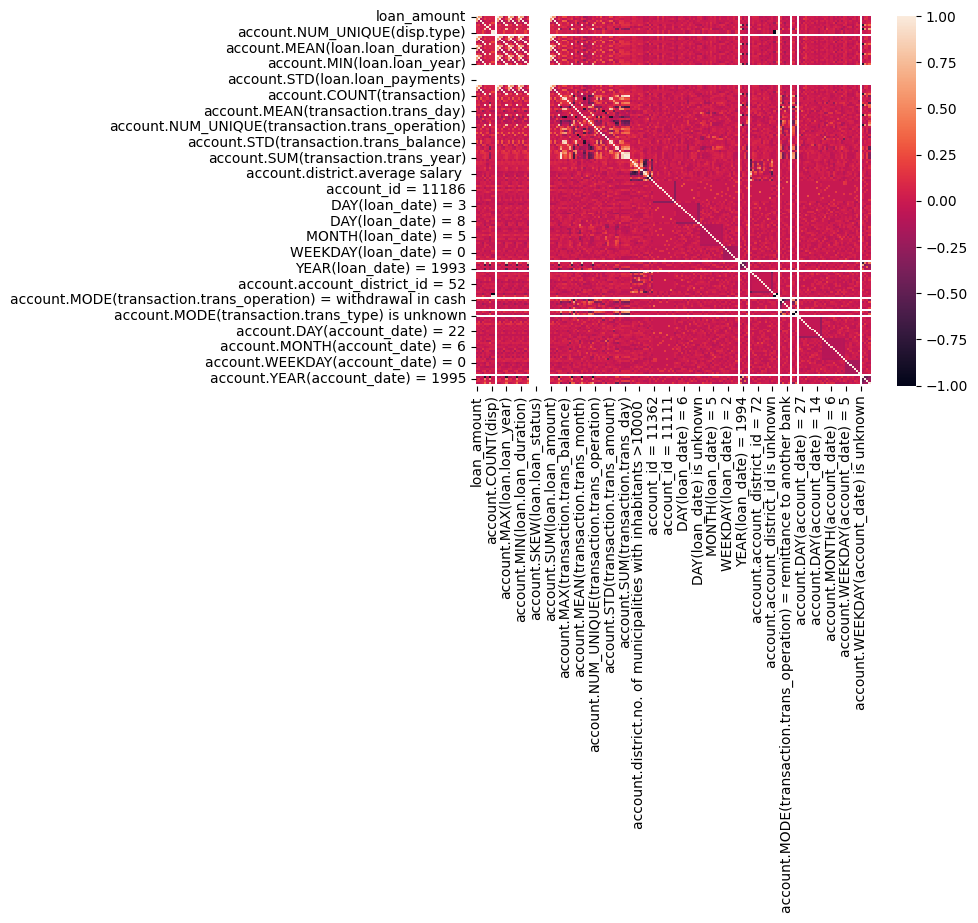

In [ ]:

print(new_feature_matrix_enc_md_2.isnull().sum())
corr = new_feature_matrix_enc_md_2.corr()
sns.heatmap(corr);

Built 87 features
Elapsed: 00:05 | Progress: 100%|██████████
[<Feature: account_id>, <Feature: loan_amount>, <Feature: loan_duration>, <Feature: loan_payments>, <Feature: loan_status>, <Feature: loan_year>, <Feature: DAY(loan_date)>, <Feature: MONTH(loan_date)>, <Feature: WEEKDAY(loan_date)>, <Feature: YEAR(loan_date)>, <Feature: account.account_district_id>, <Feature: account.account_frequency>, <Feature: account.account_year>, <Feature: account.COUNT(disp)>, <Feature: account.MODE(disp.type)>, <Feature: account.NUM_UNIQUE(disp.type)>, <Feature: account.COUNT(loan)>, <Feature: account.MAX(loan.loan_amount)>, <Feature: account.MAX(loan.loan_duration)>, <Feature: account.MAX(loan.loan_payments)>, <Feature: account.MAX(loan.loan_status)>, <Feature: account.MAX(loan.loan_year)>, <Feature: account.MEAN(loan.loan_amount)>, <Feature: account.MEAN(loan.loan_duration)>, <Feature: account.MEAN(loan.loan_payments)>, <Feature: account.MEAN(loan.loan_status)>, <Feature: account.MEAN(loan.loan_year

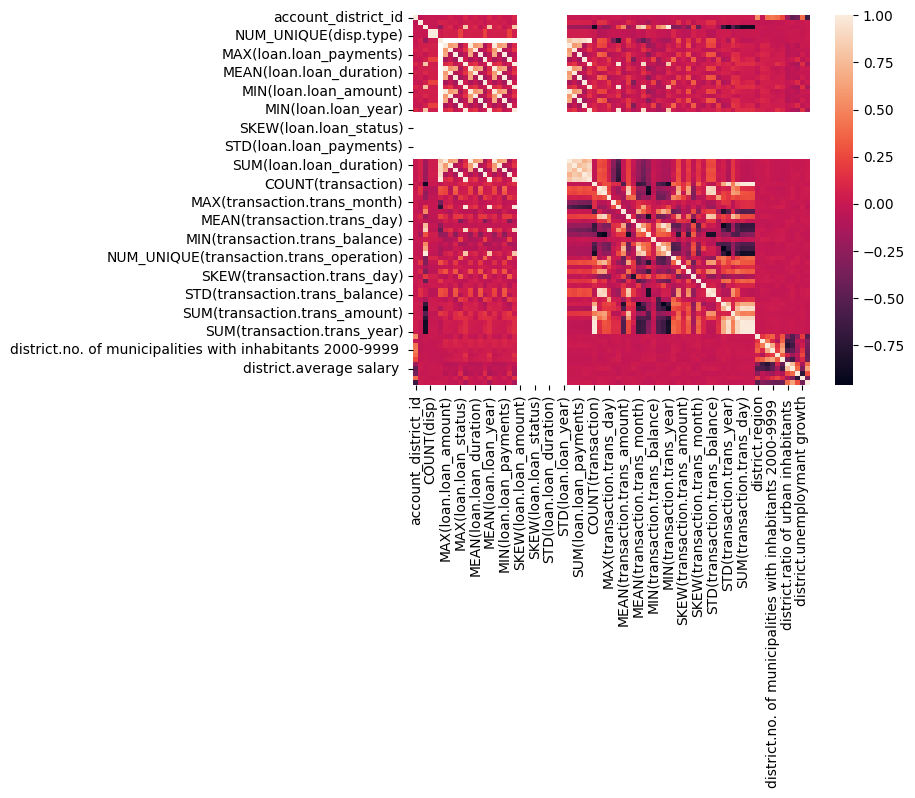

In [ ]:





features_entityset_md_4 = ft.EntitySet('features_entity', ft_dataframes, relationships)

feature_matrix_loans_md_4, features_loans_defs_md_4 = ft.dfs(
    dataframes=ft_dataframes,
    relationships=relationships,
    target_dataframe_name="account",
    max_depth = 1, verbose = 1, n_jobs = 1
    
)

feature_matrix_loans_md_4.head()
print(features_loans_defs)

feature_matrix_loans_md_4.to_csv('refined/ft_feature_matrix_loansv_md_4.csv',sep=';',index=False)
feature_matrix_loans_md_4.head()


corr = feature_matrix_loans_md_4.corr()
sns.heatmap(corr);

In [ ]:
features_entityset_md_4.plot()